In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import BaggingClassifier

In [4]:
#Here I want to test some regressors

import numpy as np
import h5py
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

In [5]:
f_halo = h5py.File('../m12i_res_7100_cdm/halo_600.hdf5')

pos_halo = f_halo['position'][:]
mass_halo = f_halo['mass'][:]
radius_halo = f_halo['radius'][:]
vel_halo = f_halo['velocity'][:]

#identify the host                                                                                                   \
                                                                                                                      
host_id = np.argmax(mass_halo)
host_mass = mass_halo[host_id]
host_pos = pos_halo[host_id]
host_vel = vel_halo[host_id]

f = h5py.File('DM_data_w_stars_training.hdf5')

coords = f['PartType1']['Coordinates'][:]
vel = f['PartType1']['Velocities'][:]
mass_ratio = f['PartType1']['Mass_Ratio'][:]

#1) attempt to save memory by reducing number of points                                                               
#   remove everything outside 400 kpc (these shouldn't)                                                               
#   factor in anyways                                                                                                 

#I think I need to merge coords and vel into a                                                                        
#2X6 array                                                                                                            

#Now this matrix is so large we run into memory errors                                                                
#                                                                                                                     
#A few potential solutions:                                                                                           
# 1) reduce the number of input points (limit to dm part within 400 kpc?) [NOPE]                                      
# 2) change algorithm (some might require less memory or some option)                                                 
#    may reduce memory                                                                                                
#    - Try using GaussianProccessRegressor module [X]                                                                 
#    - Try "bagging"                                                                                                  
# 3) run on a processor with more memory or figure out how to parallelize                                             

phase_space_coords =  np.concatenate((coords-host_pos,vel-host_vel),axis=1)

X_train, X_test, y_train, y_test = train_test_split(phase_space_coords,mass_ratio,
                                                    test_size=0.5,random_state=102)
                                                                    

In [6]:
def build_model():
    model = keras.Sequential([layers.Dense(64, activation='relu', 
                            input_shape=[len(X_train[0])]),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(1)
                             ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae','mse'])
    
    return model

print 'I guess we build this thing'

model = build_model()

I guess we build this thing


In [ ]:
EPOCHS = 100

history = model.fit(X_train, y_train, epochs=EPOCHS, verbose=1)

Train on 35257136 samples
Epoch 1/100
 9402880/35257136 [=======>......................] - ETA: 24:42 - loss: 0.0035 - mae: 0.0086 - mse: 0.0035            

0.0 7.620299327474465
0.004524599173063562
352572
-0.0012960085070535012 0.010456659652044172
0.004539546102783891


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


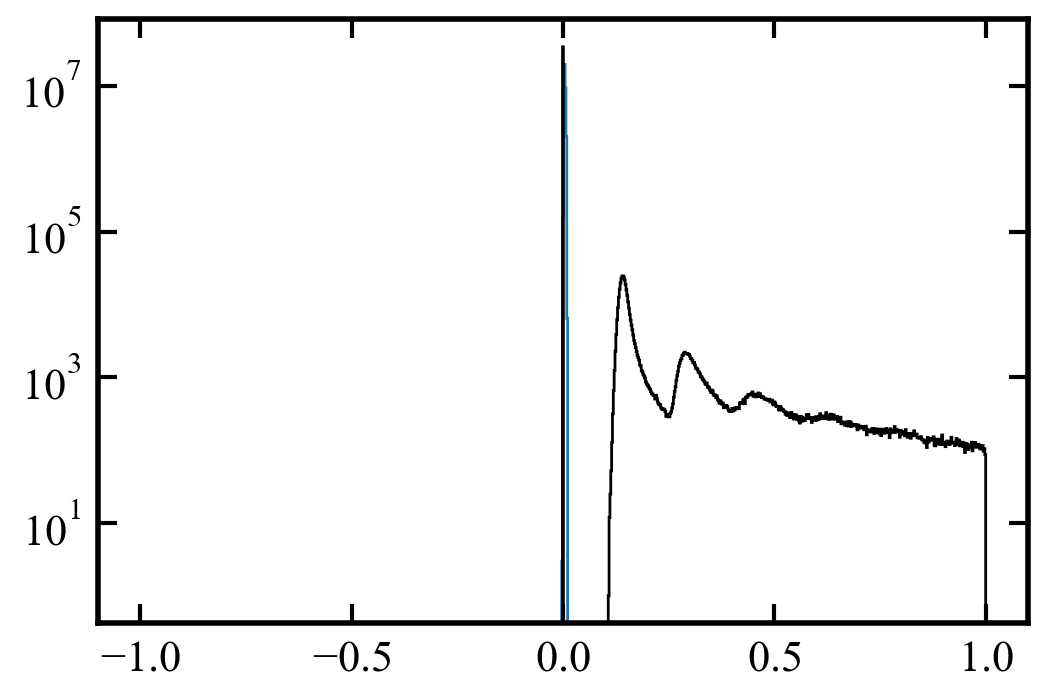

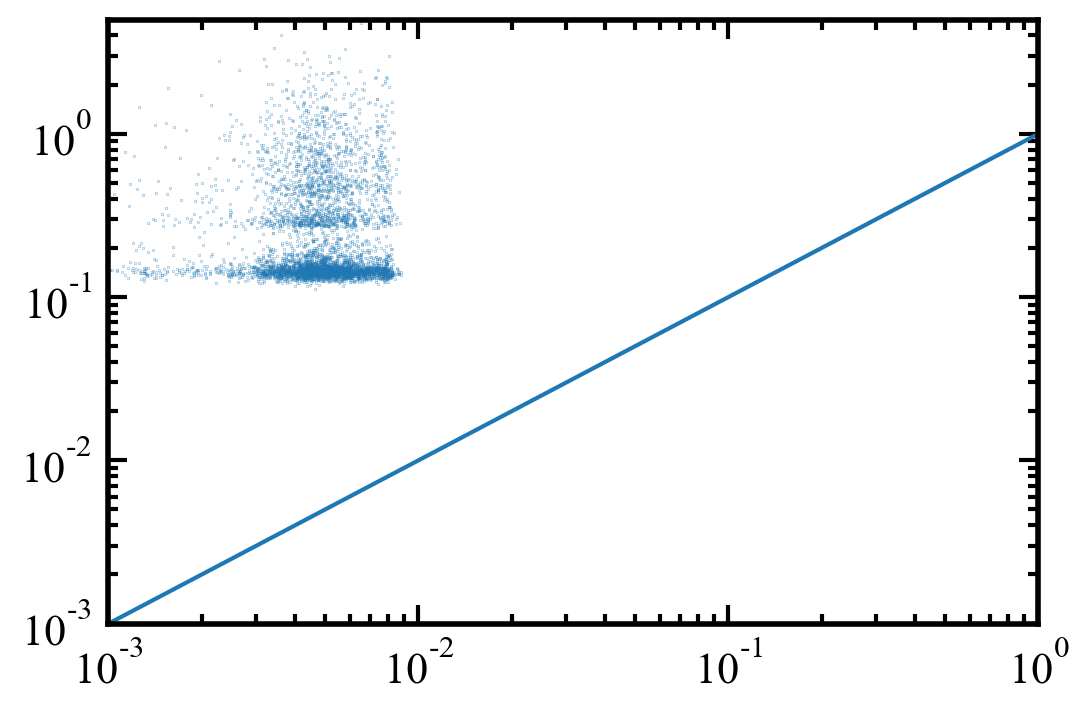

In [ ]:
#LR_error = np.divide(np.abs(np.subtract(y_test,mass_ratio_LR)),y_test)
#Lasso_error = np.divide(np.abs(np.subtract(y_test,mass_ratio_Lasso)),y_test)
#Ridge_error = np.divide(np.abs(np.subtract(y_test,mass_ratio_Ridge)),y_test)

#plt.hist(LR_error,bins=np.linspace(0.0,1.0,100),histtype='step',color='C0',normed=True)
#plt.hist(Lasso_error,bins=np.linspace(0.0,1.0,100),histtype='step',color='C1',normed=True)
#plt.hist(Ridge_error,bins=np.linspace(0.0,1.0,100),histtype='step',color='C2',normed=True)
#plt.show()

print np.min(y_test), np.max(y_test)
print np.mean(y_test)
print len(y_test[::100])

print np.min(mass_ratio_LR), np.max(mass_ratio_LR)
print np.mean(mass_ratio_LR)
hist_bins = np.linspace(-1.0,1.0,1000)

norm_val = False

plt.hist(mass_ratio_LR,bins=hist_bins,histtype='step',color='C0',normed=norm_val)
#plt.hist(mass_ratio_Lasso,bins=1000,histtype='step',color='C1',normed=norm_val)
#plt.hist(mass_ratio_Ridge,bins=hist_bins,histtype='step',color='C2',normed=norm_val)
plt.hist(y_test,bins=hist_bins,histtype='step',color='k',normed=norm_val)
#plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(mass_ratio_LR[::100],y_test[::100],s=0.01)
plt.plot([0.001,5.0],[0.001,5.0])
plt.xlim([0.001,1.0])
plt.ylim([0.001,5.0])
plt.xscale('log')
plt.yscale('log')
plt.show()


In [ ]:
#lets try a support vector machine
from sklearn.svm import NuSVR

SVR_func = NuSVR()
SVR_func.fit(X_train,y_train)
mass_ratio_SVR = SVR_func.predict(X_test)

/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
plt.hist(mass_ratio_SVR,bins=hist_bins,histtype='step',color='C0',normed=norm_val)
#plt.hist(mass_ratio_Lasso,bins=1000,histtype='step',color='C1',normed=norm_val)
#plt.hist(mass_ratio_Ridge,bins=hist_bins,histtype='step',color='C2',normed=norm_val)
plt.hist(y_test,bins=hist_bins,histtype='step',color='k',normed=norm_val)
#plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(mass_ratio_SVR[::100],y_test[::100],s=0.01)
plt.plot([0.001,5.0],[0.001,5.0])
plt.xlim([0.001,1.0])
plt.ylim([0.001,5.0])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
from sklearn.linear_model import SGDRegressor

SGD_func = SGDRegressor()
SGD_func.fit(X_train,y_train)
mass_ratio_SGD = SGD.predict(X_test)

In [ ]:
plt.hist(mass_ratio_SGD,bins=hist_bins,histtype='step',color='C0',normed=norm_val)
#plt.hist(mass_ratio_Lasso,bins=1000,histtype='step',color='C1',normed=norm_val)
#plt.hist(mass_ratio_Ridge,bins=hist_bins,histtype='step',color='C2',normed=norm_val)
plt.hist(y_test,bins=hist_bins,histtype='step',color='k',normed=norm_val)
#plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(mass_ratio_SGD[::100],y_test[::100],s=0.01)
plt.plot([0.001,5.0],[0.001,5.0])
plt.xlim([0.001,1.0])
plt.ylim([0.001,5.0])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [7]:
2+2

4

In [5]:
np.zeros((10,3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])